In [1]:
"""
Author: FengChiao Lee
Date: 07-13-2022

Loading the training result from  saved model and predict the output

"""

'\nAuthor: FengChiao Lee\nDate: 07-13-2022\n\nLoading the training result from  saved model and predict the output\n\n'

In [58]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data.dataset import Dataset
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
#from Unet_3d_model import Unet_3d
import numpy as np
import SimpleITK as sitk
import torchvision 
import torch.utils.data as data
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.parallel import DataParallel

class Unet_3d(nn.Module):
    def __init__(self, in_channel = 4, out_channel = 2, training = True):
        super(Unet_3d, self).__init__()
        self.trianing = training
        # encoder section
        self.encoder1 = nn.Sequential(
            nn.Conv3d(in_channel, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True),
            nn.Conv3d(2, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv3d(2, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True),
            nn.Conv3d(2, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv3d(4, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True),
            nn.Conv3d(4, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv3d(8, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True),
            nn.Conv3d(8, 16, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace = True)
        )

        # decoder section
        self.decoder1 = nn.Sequential(
            nn.Conv3d(24, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True),
            nn.Conv3d(8, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True)
        )
        self.decoder2 = nn.Sequential(
            nn.Conv3d(12, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True),
            nn.Conv3d(4, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True)
        )
        self.decoder3 = nn.Sequential(
            nn.Conv3d(6, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True),
            nn.Conv3d(2, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True),
            nn.Conv3d(2, 1, 3, stride = 1, padding = 1)
        )

        
    def forward(self, x):
        # encoder section
        x = self.encoder1(x)# relu(1->4)
        f1 = x #(4)
        #print("encoder1_size:",f1.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(64->64)
        #print("test",x.shape)
        x = self.encoder2(x)# relu(4->8)
        f2 = x #(8)
        #print("encoder2_size:",f2.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(128->128)
        x = self.encoder3(x)# relu(8->16)
        f3 = x #(16)
        #print("encoder3_size:",f3.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(256->256)
        x = self.encoder4(x)# relu(16->32)
        #print("endcoder4_size:", x.shape)
        
        # decoder section

        x = F.interpolate(x, scale_factor = (f3.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample(512->512)
        #print("bottleneck_size:",x.shape)
        x = torch.cat((x,f3),1) #(32+16 = 48)
        x = self.decoder1(x)# relu(48 ->16)
        #print("decoder1_size:",x.shape)
        x = F.interpolate(x, scale_factor =(f2.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample(256->256)
        x = torch.cat((x,f2),1) #(16+8 = 32) 
        x = self.decoder2(x) # relu(384 ->128)
        #print("decoder2_size:",x.shape)
        x = F.interpolate(x, scale_factor =(f1.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample(128->128)
        x = torch.cat((x,f1),1) #(8+4 = 12) 
        x = self.decoder3(x) # relu(192 ->2)
        #print("decoder3_size:",x.shape)
        
        return x       


In [59]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data.dataset import Dataset
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
#from Unet_3d_model import Unet_3d
import numpy as np
import SimpleITK as sitk
import torchvision 
import torch.utils.data as data
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [60]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data.dataset import Dataset
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
#from Unet_3d_model import Unet_3d
import numpy as np
import SimpleITK as sitk
import torchvision 
import torch.utils.data as data
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils import to_one_hot_3d
from utils import BalancedDataParallel

In [61]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size =3, stride =1, padding =1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size =3, stride =1, padding =1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size =3, stride =1, padding =1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
            )
        self.relu = nn.ReLU(inplace = True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.shape)
        #print(x1.shape)
        g1 = F.interpolate(g1, scale_factor = (x1.shape[2]/g1.shape[2],0.5,0.5), mode = 'trilinear')
        #print(g1.shape)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        #print(psi.shape)

        return x*psi

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace = True),
            nn.Conv3d(ch_in, ch_out, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace = True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor =2),
            nn.Conv3d(ch_in,ch_out,3,stride =1 ,padding =1),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inpalce =True)
        )
    def forward(self, x):
        x =self.up(x)
        return x    



class Att_Unet(nn.Module):
    def __init__(self, in_channel = 4, out_channel = 2, training = True):
        super(Att_Unet, self).__init__()
        self.trianing = training
        # encoder section
        self.encoder1 = nn.Sequential(
            nn.Conv3d(in_channel, 2, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(2),
            nn.ReLU(inplace = True),
            nn.Conv3d(2, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv3d(4, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True),
            nn.Conv3d(4, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv3d(8, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True),
            nn.Conv3d(8, 16, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace = True)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv3d(16, 16, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace = True)
        )
        self.att1 = Attention_block(F_g =16, F_l =16, F_int =16)
        self.encoder5 = nn.Sequential(
            nn.Conv3d(16, 32, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace = True)
        )

        # decoder section
        self.decoder1 = nn.Sequential(
            nn.Conv3d(48, 16, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace = True)
        )
        self.att2 = Attention_block(F_g=8, F_l=16, F_int =16)
        self.decoder2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace = True)
        )
        self.decoder3 = nn.Sequential(
            nn.Conv3d(32, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True)
        )
        self.att3 = Attention_block(F_g =4, F_l=8, F_int =8)
        self.decoder4 = nn.Sequential(
            nn.Conv3d(8, 8, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU(inplace = True)
        )
        self.decoder5 = nn.Sequential(
            nn.Conv3d(16, 4, 3, stride = 1, padding = 1),
            nn.BatchNorm3d(4),
            nn.ReLU(inplace = True)
        )
        self.decoder6 = nn.Sequential(
            nn.Conv3d(4, out_channel, 3, stride = 1, padding = 1)
        )


        
    def forward(self, x):
        # encoder section
        #print('origin:',x.shape)
        x = self.encoder1(x)# relu(4->8)
        f1 = x #(8)
        #print('f1:',x.shape)
        #print("encoder1_size:",f1.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(8->8)
        #print("test",x.shape)
        x = self.encoder2(x)# relu(8->16)
        f2 = x #(16)
        # print('f2:',x.shape)
        #print("encoder2_size:",f2.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(16->16)
        x = self.encoder3(x)# relu(16->32)
        f3 = x #(32)
        #print('f3:',x.shape)
        #print("encoder3_size:",f3.shape)
        x = F.max_pool3d(x,kernel_size = 2,stride = 2,padding = 0)# maxpool(32->32)
        x = self.encoder4(x)# relu(32->32)
        a1 = x
        #print('x:',x.shape)
        A1 = self.att1(g = f3, x =a1)#attention block1
        #print('A1:',A1.shape)
        x = self.encoder5(x)#relu(32->64)
        #print('x:',x.shape)
        
        # decoder section

        x = F.interpolate(x, scale_factor = (f3.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample（16->16)
        #print('x:',x.shape)
        A1 = F.interpolate(A1, scale_factor = (f3.shape[2]/A1.shape[2],2,2), mode = 'trilinear')# upsample（16->16)
        #print('A1:',A1.shape)
        x = torch.cat((x,A1),1) #(64+32 = 96)
        #print('x:',x.shape)
        x = self.decoder1(x)# relu(96 ->32)
        #print('x:',x.shape)
        a2 = x#attention block2, size = 32
        #print('a2:',a2.shape)
        #print('f2:',f2.shape)
        A2 = self.att2(g =f2,x=a2) # size =32
        #print('A2',A2.shape)
        A2 = F.interpolate(A2, scale_factor = (f2.shape[2]/A2.shape[2],2,2), mode = 'trilinear')# upsample（16->16)

        #print("decoder1_size:",x.shape)
        x = self.decoder2(x)#relu(32->32)
        #print('x:',x.shape)
        x = F.interpolate(x, scale_factor =(f2.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample(256->256)
        #print('A2:',A2.shape)
        x = torch.cat((x,A2),1) #(4+4 = 8) 
        #print('x:',x.shape)
        x = self.decoder3(x) # relu(8 ->2)
        #print('x:',x.shape)
        #print("decoder2_size:",x.shape)
        a3 = x#attention block2
        #print('a3:',a3.shape)
        A3 = self.att3(g =f1,x=a3)
        #print('x:',x.shape)
        A3 = F.interpolate(A3, scale_factor = (f1.shape[2]/A3.shape[2],2,2), mode = 'trilinear')# upsample（16->16)
        #print('A3:',A3.shape)
        x = self.decoder4(x)#relu(2->2)
        #print('x:',x.shape)
        x = F.interpolate(x, scale_factor =(f1.shape[2]/x.shape[2],2,2), mode = 'trilinear')# upsample(128->128)
        #print('x:',x.shape)
        x = torch.cat((x,A3),1) #(2+2 = 4)
        #print('x:',x.shape) 
        x = self.decoder5(x) # relu(4 ->2)
        #print('x:',x.shape)
        #print("decoder3_size:",x.shape)
        x = self.decoder6(x)
        #print('x:',x.shape)
        
        return x 
    
def scatter(inputs, target_gpus, chunk_sizes, dim=0):
    """
    Slices tensors into approximately equal chunks and
    distributes them across given GPUs. Duplicates
    references to objects that are not tensors.

    # Source code: https://github.com/kimiyoung/transformer-xl
    """
    def scatter_map(obj):
        if isinstance(obj, torch.Tensor):
            try:
                return Scatter.apply(target_gpus, chunk_sizes, dim, obj)
            except:
                print('obj', obj.size())
                print('dim', dim)
                print('chunk_sizes', chunk_sizes)
                quit()
        if isinstance(obj, tuple) and len(obj) > 0:
            return list(zip(*map(scatter_map, obj)))
        if isinstance(obj, list) and len(obj) > 0:
            return list(map(list, zip(*map(scatter_map, obj))))
        if isinstance(obj, dict) and len(obj) > 0:
            return list(map(type(obj), zip(*map(scatter_map, obj.items()))))
        return [obj for targets in target_gpus]

    """
        After scatter_map is called, a scatter_map cell will exist. This cell
        has a reference to the actual function scatter_map, which has references
        to a closure that has a reference to the scatter_map cell (because the
        fn is recursive). To avoid this reference cycle, we set the function to
        None, clearing the cell
    """

    try:
        return scatter_map(inputs)
    finally:
        scatter_map = None

def scatter_kwargs(inputs, kwargs, target_gpus, chunk_sizes, dim=0):
    r"""Scatter with support for kwargs dictionary"""
    inputs = scatter(inputs, target_gpus, chunk_sizes, dim) if inputs else []
    kwargs = scatter(kwargs, target_gpus, chunk_sizes, dim) if kwargs else []
    if len(inputs) < len(kwargs):
        inputs.extend([() for _ in range(len(kwargs) - len(inputs))])
    elif len(kwargs) < len(inputs):
        kwargs.extend([{} for _ in range(len(inputs) - len(kwargs))])
    inputs = tuple(inputs)
    kwargs = tuple(kwargs)
    return inputs, kwargs

class BalancedDataParallel(DataParallel):
    def __init__(self, gpu0_bsz, *args, **kwargs):
        self.gpu0_bsz = gpu0_bsz
        super().__init__(*args, **kwargs)

    def forward(self, *inputs, **kwargs):
        if not self.device_ids:
            return self.module(*inputs, **kwargs)
        if self.gpu0_bsz == 0:
            device_ids = self.device_ids[1:]
        else:
            device_ids = self.device_ids
        inputs, kwargs = self.scatter(inputs, kwargs, device_ids)
        if len(self.device_ids) == 1:
            return self.module(*inputs[0], **kwargs[0])
        replicas = self.replicate(self.module, self.device_ids)
        if self.gpu0_bsz == 0:
            replicas = replicas[1:]
        outputs = self.parallel_apply(replicas, device_ids, inputs, kwargs)
        return self.gather(outputs, self.output_device)

    def parallel_apply(self, replicas, device_ids, inputs, kwargs):
        return parallel_apply(replicas, inputs, kwargs, device_ids)

    def scatter(self, inputs, kwargs, device_ids):
        bsz = inputs[0].size(self.dim)
        num_dev = len(self.device_ids)
        gpu0_bsz = self.gpu0_bsz
        bsz_unit = (bsz - gpu0_bsz) // (num_dev - 1)
        if gpu0_bsz < bsz_unit:
            chunk_sizes = [gpu0_bsz] + [bsz_unit] * (num_dev - 1)
            delta = bsz - sum(chunk_sizes)
            for i in range(delta):
                chunk_sizes[i + 1] += 1
            if gpu0_bsz == 0:
                chunk_sizes = chunk_sizes[1:]
        else:
            return super().scatter(inputs, kwargs, device_ids)

        # print('bsz: ', bsz)
        # print('num_dev: ', num_dev)
        # print('gpu0_bsz: ', gpu0_bsz)
        # print('bsz_unit: ', bsz_unit)
        # print('chunk_sizes: ', chunk_sizes)
        return scatter_kwargs(inputs, kwargs, device_ids, chunk_sizes, dim=self.dim)




In [62]:

att_path = r'S:\StrokeAI\Try\3dUnet\checkpoint\para_comunet_BCE1207.pt'
unet_path = r'S:\StrokeAI\Try\3dUnet\checkpoint\best_model_072209pm.pt'

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint =torch.load(att_path, map_location=device)

In [71]:
def load_checkpoint(filepath):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint =torch.load(filepath, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:]
        new_state_dict[name] = v
        
    model = checkpoint['model']
    model.load_state_dict(new_state_dict, strict = False)
    optimizer = optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model, checkpoint

In [72]:
attmodel, attcheckpoint = load_checkpoint(att_path)
unetmodel, unetcheckpoint = load_checkpoint(unet_path)
#checkpoint =torch.load(att_path, map_location=device)

In [46]:
print(set(attcheckpoint['test_name']) & set(unetcheckpoint['test_name']))

{('BRATS_331.nii.gz',)}


Text(0, 0.5, 'dice/loss')

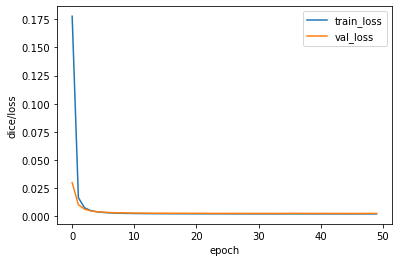

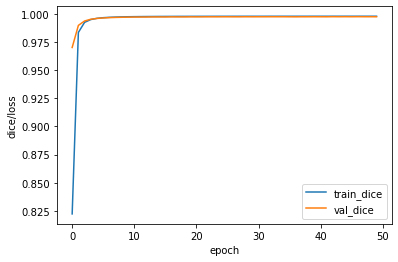

In [73]:
train_loss =checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_dice =checkpoint['train_dice']
val_dice = checkpoint['val_dice']
plt.figure(1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train_loss",'val_loss'])
plt.xlabel('epoch')
plt.ylabel('dice/loss')
plt.figure(2)
plt.plot(train_dice)
plt.plot(val_dice)
plt.legend(["train_dice",'val_dice'])
plt.xlabel('epoch')
plt.ylabel('dice/loss')

In [92]:
unetcheckpoint['val_dice']

[0.06741837859153747,
 0.06772188544273376,
 0.07403799295425414,
 0.07724083662033081,
 0.08192334175109864,
 0.08445714712142945,
 0.09036411046981811,
 0.09768971800804138,
 0.10284991264343261,
 0.1160132884979248,
 0.12441308498382568,
 0.13679757118225097,
 0.1471158266067505,
 0.16341567039489746,
 0.17771724462509156,
 0.18615362644195557,
 0.20944743156433104,
 0.22951040267944336,
 0.24587292671203614,
 0.26739158630371096,
 0.2834100484848022,
 0.3061940670013428,
 0.3193089008331299,
 0.3406625270843506,
 0.38246593475341795,
 0.377103853225708,
 0.44069795608520507,
 0.46098647117614744,
 0.48516178131103516,
 0.4991940498352051,
 0.5324331760406494,
 0.5609809875488281,
 0.5692995548248291,
 0.6091269493103028,
 0.6385797500610352,
 0.6730726718902588,
 0.7030399322509766,
 0.7113144397735596,
 0.717248010635376,
 0.7251802921295166,
 0.7459795475006104,
 0.7607610702514649,
 0.722083330154419,
 0.8036686897277832,
 0.7938218593597413,
 0.8198315620422363,
 0.839059162139

In [74]:
test_image_path = r'S:\StrokeAI\Try\3dUnet\TestData\Task01_BrainTumour\Task01_BrainTumour\imagesTr\BRATS_307.nii.gz'

In [75]:
test_img = sitk.ReadImage(test_image_path)
direct = test_img.GetDirection()
print(direct)
test_img = sitk.GetArrayFromImage(test_img)
test_tensor = torch.FloatTensor(test_img)

(-1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0)


In [76]:
with torch.no_grad():
    output = attmodel.forward(test_tensor.unsqueeze(0))

AttributeError: module 'torch._C' has no attribute '_scatter'

In [67]:
output.squeeze().shape

torch.Size([155, 240, 240])

In [68]:
test_label = output.squeeze().cpu().data.numpy()
test_label[test_label<0]=0

In [69]:
test_label.shape

(155, 240, 240)

In [70]:
%cd S:/StrokeAI/Try/3dUnet/Pred

S:\StrokeAI\Try\3dUnet\Pred


In [71]:
test_label = sitk.GetImageFromArray(test_label)

sitk.WriteImage(test_label, '307_att.nii.gz')


In [72]:
def pixel_error(path1, path2):
    img1 = sitk.ReadImage(path1)
    img1 = sitk.GetArrayFromImage(img1)
    img2 = sitk.ReadImage(path2)
    img2 = sitk.GetArrayFromImage(img2)
    img1[img1>0] = 1
    img1[img1<=0] = 0
    img2[img2>0] = 1
    img2[img2<=0] = 0
    num = abs(sum(sum(sum(img1-img2))))
    total = img1.shape[0]*img1.shape[1]*img1.shape[2]
    return  num/total
    
    

In [73]:
attpath1 = r'S:\StrokeAI\Try\3dUnet\Pred\307_att.nii.gz'
unetpath2 = r'S:\StrokeAI\Try\3dUnet\Pred\307_unet.nii.gz'
labelpath = r'S:\StrokeAI\Try\3dUnet\TestData\Task01_BrainTumour\Task01_BrainTumour\labelsTr\BRATS_307.nii.gz'

In [75]:
print('att_err:',pixel_error(attpath1,labelpath))
print('unet_err:',pixel_error(unetpath2,labelpath))

att_err: 0.001710125448028674
unet_err: 0.0018702956989247311


In [80]:
import imageio

In [93]:
path = 'S:/StrokeAI/Try/3dUnet/Pred/307_unet_Axial/'

In [94]:
def saveGif(path,save_name):
    path = path
    name_list = []
    for i in os.listdir(path):
        name = path + i
        name_list.append(name)
    name_list.sort()
    images=[]
    for i in name_list:
        images.append(imageio.imread(i))
    imageio.mimsave(f'{save_name}',images,duration =0.1)

In [95]:
saveGif(path,'307_unet_Axial.gif')

In [ ]:
images=[]

In [ ]:
for i in name_list:
    images.append(imageio.imread(i))
imageio.mimsave('348.gif',images,duration =0.1)

In [ ]:
len(images)